# Measures branching in C++ from python

This notebook looks into a couple of ways to write code, which one is efficient, which one is not when it comes to write fast and short loops. Both experiments are around [branching](https://en.wikipedia.org/wiki/Branch_predictor). The notebook relies on C++ code implemented in [cbenchmark.cpp](https://github.com/sdpython/cpyquickhelper/blob/master/src/cpyquickhelper/numbers/cbenchmark.cpp) and
[repeat_fct.h](https://github.com/sdpython/cpyquickhelper/blob/master/src/cpyquickhelper/numbers/repeat_fct.h).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

[numpy](http://www.numpy.org/) is multithreaded. For an accurate comparison, this needs to be disabled. This can be done as follows or by setting environment variable ``MKL_NUM_THREADS=1``.

In [3]:
try:
    import mkl
    mkl.set_num_threads(1)
except ModuleNotFoundError as e:
    print('mkl not found', e)
    import os
    os.environ['MKL_NUM_THREADS']='1'

## First experiment: comparison C++ syntax

This all started with article [Why is it faster to process a sorted array than an unsorted array?](https://stackoverflow.com/questions/11227809/why-is-it-faster-to-process-a-sorted-array-than-an-unsorted-array/11227902#11227902). It compares different implementation fo the following function for which we try different implementations for the third line in next cell. The last option is taken
[Checking whether a number is positive or negative using bitwise operators](https://stackoverflow.com/questions/3779202/checking-whether-a-number-is-positive-or-negative-using-bitwise-operators) which avoids [branching](https://en.wikipedia.org/wiki/Branch_predictor).

In [4]:
# int nb = 0;
# for(auto it = values.begin(); it != values.end(); ++it)
#     if (*it >= th) nb++; // this line changes
#     if (*it >= th) nb++; // and is repeated 10 times inside the loop.
#     // ... 10 times
# return nb;

The third line is also repeated 10 times to avoid the loop being too significant. 

In [5]:
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_A, measure_scenario_B
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_C, measure_scenario_D
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_E, measure_scenario_F
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_G, measure_scenario_H
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_I, measure_scenario_J

In [6]:
import pandas

def test_benchmark(label, values, th, repeat=10, number=20):
    funcs = [(k, v) for k, v in globals().copy().items() if k.startswith("measure_scenario")]
    rows = []
    for k, v in funcs:
        exe = v(values, th, repeat, number)
        d = exe.todict()
        d['doc'] = v.__doc__.split('``')[1]
        d['label'] = label
        d['name'] = k
        rows.append(d)        
    df = pandas.DataFrame(rows)
    return df

test_benchmark("sorted", list(range(10)), 5)

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,5.728500e-07,5.789527e-07,if (values[i] >= th) ++nb;,sorted,1.186000e-06,7.900000e-07,measure_scenario_A,20.0,10.0
1,5.333500e-07,5.485149e-07,if (*it >= th) ++nb;,sorted,1.186000e-06,7.900000e-07,measure_scenario_B,20.0,10.0
2,5.531000e-07,5.642499e-07,if (*it >= th) nb++;,sorted,1.186000e-06,7.900000e-07,measure_scenario_C,20.0,10.0
3,1.382500e-07,1.884030e-07,nb += *it >= th ? 1 : 0;,sorted,3.950000e-07,0.000000e+00,measure_scenario_D,20.0,10.0
4,5.531000e-07,5.642849e-07,if (*it >= th) nb += 1;,sorted,1.186000e-06,7.900000e-07,measure_scenario_E,20.0,10.0
5,1.185500e-07,1.810882e-07,nb += (*it - th) >= 0 ? 1 : 0;,sorted,3.960000e-07,0.000000e+00,measure_scenario_F,20.0,10.0
6,1.383000e-07,1.884712e-07,nb += (*it - th) < 0 ? 1 : 0;,sorted,3.960000e-07,0.000000e+00,measure_scenario_G,20.0,10.0
7,1.185000e-07,1.810117e-07,nb += *it < th ? 1 : 0;,sorted,3.950000e-07,0.000000e+00,measure_scenario_H,20.0,10.0
8,1.580500e-07,1.935710e-07,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,3.960000e-07,0.000000e+00,measure_scenario_I,20.0,10.0
9,7.905000e-08,1.581001e-07,nb += values[i] >= th ? 1 : 0;,sorted,3.960000e-07,0.000000e+00,measure_scenario_J,20.0,10.0


Times are not very conclusive on such small lists.

In [7]:
values = list(range(100000))
df_sorted = test_benchmark("sorted", values, len(values)//2, repeat=200)
df_sorted

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.136862,0.0,if (values[i] >= th) ++nb;,sorted,0.021955,0.013029,measure_scenario_A,20.0,200.0
1,0.139063,0.0,if (*it >= th) ++nb;,sorted,0.017009,0.013001,measure_scenario_B,20.0,200.0
2,0.132236,0.0,if (*it >= th) nb++;,sorted,0.014134,0.013002,measure_scenario_C,20.0,200.0
3,0.013740,0.0,nb += *it >= th ? 1 : 0;,sorted,0.002426,0.001293,measure_scenario_D,20.0,200.0
4,0.136580,0.0,if (*it >= th) nb += 1;,sorted,0.017889,0.013002,measure_scenario_E,20.0,200.0
5,0.015208,0.0,nb += (*it - th) >= 0 ? 1 : 0;,sorted,0.002863,0.001294,measure_scenario_F,20.0,200.0
6,0.016229,0.0,nb += (*it - th) < 0 ? 1 : 0;,sorted,0.004782,0.001461,measure_scenario_G,20.0,200.0
7,0.013643,0.0,nb += *it < th ? 1 : 0;,sorted,0.002153,0.001297,measure_scenario_H,20.0,200.0
8,0.026053,0.0,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,0.004270,0.002405,measure_scenario_I,20.0,200.0
9,0.015237,0.0,nb += values[i] >= th ? 1 : 0;,sorted,0.002677,0.001457,measure_scenario_J,20.0,200.0


The article some implementations will be slower if the values are not sorted.

In [8]:
import random
random.shuffle(values)
values = values.copy()
values[:10]

[48365, 87890, 41678, 46385, 65651, 61946, 21980, 48529, 87219, 29551]

In [9]:
df_shuffled = test_benchmark("shuffled", values, len(values)//2, repeat=200)
df_shuffled

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.134693,0.0,if (values[i] >= th) ++nb;,shuffled,0.016256,0.012956,measure_scenario_A,20.0,200.0
1,0.133707,0.0,if (*it >= th) ++nb;,shuffled,0.015030,0.012998,measure_scenario_B,20.0,200.0
2,0.133024,0.0,if (*it >= th) nb++;,shuffled,0.014811,0.012997,measure_scenario_C,20.0,200.0
3,0.013992,0.0,nb += *it >= th ? 1 : 0;,shuffled,0.002802,0.001293,measure_scenario_D,20.0,200.0
4,0.134017,0.0,if (*it >= th) nb += 1;,shuffled,0.015806,0.013003,measure_scenario_E,20.0,200.0
5,0.014059,0.0,nb += (*it - th) >= 0 ? 1 : 0;,shuffled,0.002515,0.001294,measure_scenario_F,20.0,200.0
6,0.014952,0.0,nb += (*it - th) < 0 ? 1 : 0;,shuffled,0.001947,0.001461,measure_scenario_G,20.0,200.0
7,0.013271,0.0,nb += *it < th ? 1 : 0;,shuffled,0.002554,0.001298,measure_scenario_H,20.0,200.0
8,0.024356,0.0,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,shuffled,0.003141,0.002405,measure_scenario_I,20.0,200.0
9,0.015286,0.0,nb += values[i] >= th ? 1 : 0;,shuffled,0.002744,0.001457,measure_scenario_J,20.0,200.0


In [10]:
df = pandas.concat([df_sorted, df_shuffled])
dfg = df[["doc", "label", "average"]].pivot("doc", "label", "average")

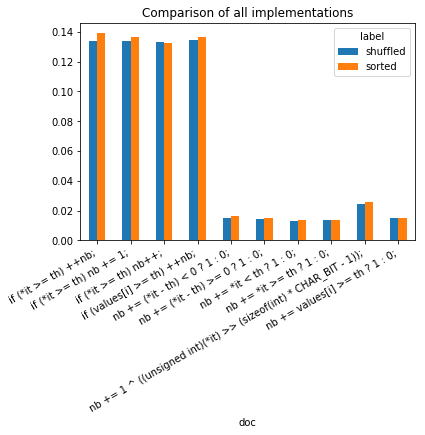

In [11]:
ax = dfg.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of all implementations");

It seems that inline tests (``cond ? value1 : value2``) do not stop the branching and it should be used whenever possible.

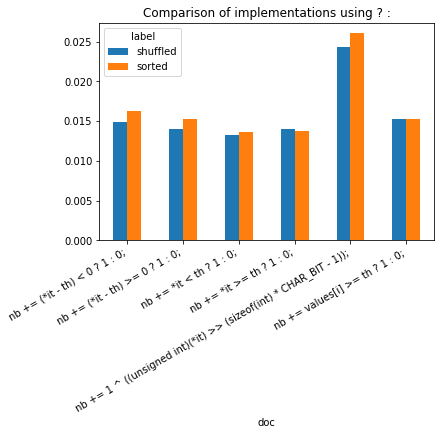

In [12]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('[?^]')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of implementations using ? :");

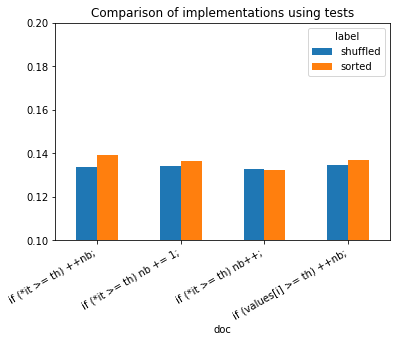

In [13]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('if')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_ylim([0.10, 0.20])
ax.set_title("Comparison of implementations using tests");

*sorted*, *not sorted* does not seem to have a real impact in this case. It shows *branching* really slows down the execution of a program. Branching happens whenever the program meets a loop condition or a test. Iterator ``*it`` are faster than accessing an array with notation ``[i]`` which adds a cost due to an extra addition.

## Second experiment: dot product

The goal is to compare the dot product from [numpy.dot](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html) and a couple of implementation in C++ which look like this:

In [14]:
# float vector_dot_product_pointer(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     const float * end1 = p1 + size;
#     for(; p1 != end1; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# 
# float vector_dot_product(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer(v1.data(0), v2.data(0), v1.shape(0));
# }

### numpy vs C++

In [15]:
%matplotlib inline

In [16]:
import numpy

def simple_dot(values):
    return numpy.dot(values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot(vect)

3333333.2

In [17]:
vect.dtype

dtype('float32')

In [18]:
from timeit import Timer

def measure_time(stmt, context, repeat=10, number=50):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                size=context['values'].shape[0])

measure_time("simple_dot(values)", context=dict(simple_dot=simple_dot, values=vect))

{'average': 0.12551415209997002,
 'deviation': 0.012892999741123123,
 'min_exec': 0.11487823799996022,
 'max_exec': 0.15420459599999958,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [19]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("simple_dot(values)", repeat=100,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
dot = pandas.DataFrame(res)
dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001137,0.000044,0.001362,0.001116,50,100,187510
76,0.001141,0.000038,0.001346,0.001122,50,100,190010
77,0.001148,0.000020,0.001244,0.001136,50,100,192510
78,0.001168,0.000021,0.001261,0.001152,50,100,195010
79,0.001348,0.000394,0.002692,0.001165,50,100,197510


In [20]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("simple_dot(values)", repeat=10,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)
    
huge_dot = pandas.DataFrame(res)
huge_dot.head()

,average,deviation,max_exec,min_exec,number,repeat,size
0,0.001075,0.000410,0.001722,0.000591,50,10,100000
1,0.011456,0.002504,0.015181,0.007934,50,10,1100000
2,0.032301,0.004606,0.043542,0.026140,50,10,2100000
3,0.040916,0.004739,0.046942,0.033876,50,10,3100000
4,0.045737,0.001285,0.048492,0.044516,50,10,4100000


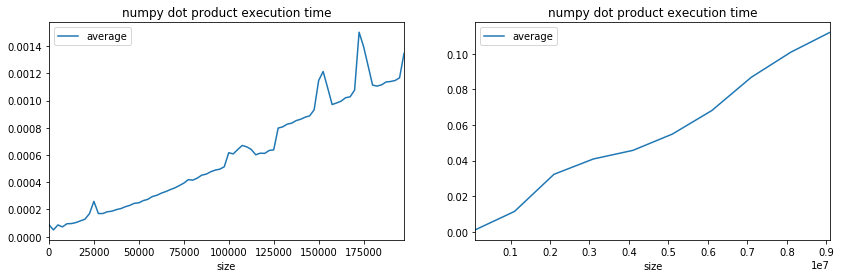

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0])
huge_dot.plot(x='size', y="average", ax=ax[1])
ax[0].set_title("numpy dot product execution time");
ax[1].set_title("numpy dot product execution time");

Now the custom implementation. We start with an empty function to get a sense of the cost due to to pybind11.

In [22]:
from cpyquickhelper.numbers.cbenchmark_dot import empty_vector_dot_product
empty_vector_dot_product(vect, vect)

0.0

In [23]:
def empty_c11_dot(vect):
    return empty_vector_dot_product(vect, vect)

measure_time("empty_c11_dot(values)", context=dict(empty_c11_dot=empty_c11_dot, values=vect), repeat=10)

{'average': 8.280469999135675e-05,
 'deviation': 2.481106475472426e-05,
 'min_exec': 6.321000000752974e-05,
 'max_exec': 0.00013787600005343847,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

Very small. It should not pollute our experiments.

In [24]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product
vector_dot_product(vect, vect)

3334629.0

In [25]:
def c11_dot(vect):
    return vector_dot_product(vect, vect)

measure_time("c11_dot(values)", context=dict(c11_dot=c11_dot, values=vect), repeat=10)

{'average': 0.6883779342999901,
 'deviation': 0.014281541145824214,
 'min_exec': 0.6709101500000543,
 'max_exec': 0.7089845589999868,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [26]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot(values)", repeat=10,
                     context=dict(c11_dot=c11_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
cus_dot = pandas.DataFrame(res)
cus_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.012365,0.000064,0.012501,0.012278,50,10,187510
76,0.012442,0.000029,0.012490,0.012377,50,10,190010
77,0.012798,0.000198,0.013193,0.012547,50,10,192510
78,0.012882,0.000109,0.013175,0.012777,50,10,195010
79,0.013287,0.000306,0.014023,0.012913,50,10,197510


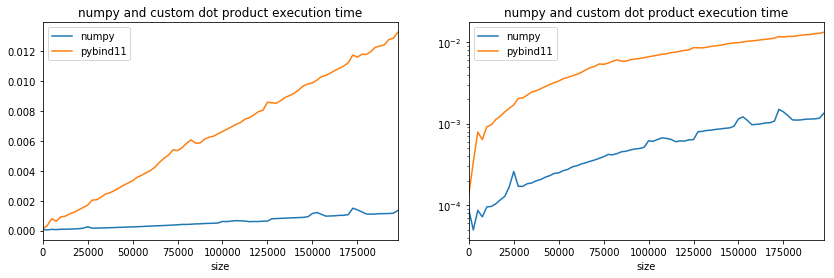

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Pretty slow. Let's see what it does to compute dot product 16 by 16.

### Use of branching: 16 multplications in one row

The code looks like what follows. If there is more than 16 multiplications left, we use function *vector_dot_product_pointer16*, otherwise, there are done one by one like the previous function.

In [28]:
# float vector_dot_product_pointer16(const float *p1, const float *p2)
# {
#     float sum = 0;
#     
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     return sum;
# }
# 
# #define BYN 16
# 
# float vector_dot_product_pointer16(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     size_t i = 0;
#     if (size >= BYN) {
#         size_t size_ = size - BYN;
#         for(; i < size_; i += BYN, p1 += BYN, p2 += BYN)
#             sum += vector_dot_product_pointer16(p1, p2);
#     }
#     for(; i < size; ++p1, ++p2, ++i)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16(v1.data(0), v2.data(0), v1.shape(0));
# }

In [29]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16
vector_dot_product16(vect, vect)

3333331.75

In [30]:
def c11_dot16(vect):
    return vector_dot_product16(vect, vect)

measure_time("c11_dot16(values)", context=dict(c11_dot16=c11_dot16, values=vect), repeat=10)

{'average': 0.3249879705000126,
 'deviation': 0.02298626004011859,
 'min_exec': 0.3086359569999786,
 'max_exec': 0.3783302670000239,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [31]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16(values)", repeat=10,
                     context=dict(c11_dot16=c11_dot16, values=vect[:i].copy()))
    res.append(t)

cus_dot16 = pandas.DataFrame(res)
cus_dot16.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.005494,0.000173,0.005939,0.005330,50,10,187510
76,0.005479,0.000109,0.005678,0.005403,50,10,190010
77,0.005757,0.000220,0.006221,0.005477,50,10,192510
78,0.006239,0.000625,0.007619,0.005541,50,10,195010
79,0.007218,0.001312,0.010175,0.005873,50,10,197510


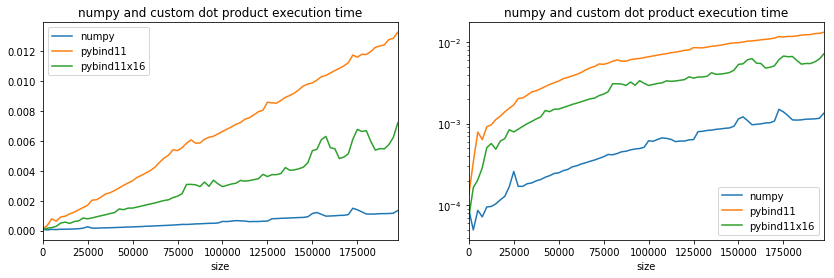

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

We are far from *numpy* but the branching has clearly a huge impact and the fact the loop condition is evaluated only every 16 iterations does not explain this gain. Next experiment with [SSE](https://fr.wikipedia.org/wiki/Streaming_SIMD_Extensions) instructions.

### Optimized to remove function call

We remove the function call to get the following version.

In [33]:
# float vector_dot_product_pointer16_nofcall(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;    
#     const float * end = p1 + size;
#     if (size >= BYN) {
#         #if(BYN != 16)
#             #error "BYN must be equal to 16";
#         #endif
#         unsigned int size_ = (unsigned int) size;
#         size_ = size_ >> 4;  // division by 16=2^4
#         size_ = size_ << 4;  // multiplication by 16=2^4
#         const float * end_ = p1 + size_;
#         for(; p1 != end_;)
#         {
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
# 
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#         }
#     }
#     for(; p1 != end; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16_nofcall(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16_nofcall(v1.data(0), v2.data(0), v1.shape(0));
# }

In [34]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_nofcall
vector_dot_product16_nofcall(vect, vect)

3334629.0

In [35]:
def c11_dot16_nofcall(vect):
    return vector_dot_product16_nofcall(vect, vect)

measure_time("c11_dot16_nofcall(values)",
             context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect), repeat=10)

{'average': 0.706979583799989,
 'deviation': 0.01947396555851374,
 'min_exec': 0.6781796689999737,
 'max_exec': 0.739977101999898,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [36]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_nofcall(values)", repeat=10,
                     context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect[:i].copy()))
    res.append(t)

cus_dot16_nofcall = pandas.DataFrame(res)
cus_dot16_nofcall.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.012379,0.000164,0.012792,0.012219,50,10,187510
76,0.012468,0.000046,0.012537,0.012383,50,10,190010
77,0.012738,0.000161,0.013196,0.012629,50,10,192510
78,0.013003,0.000181,0.013258,0.012774,50,10,195010
79,0.013135,0.000144,0.013410,0.012868,50,10,197510


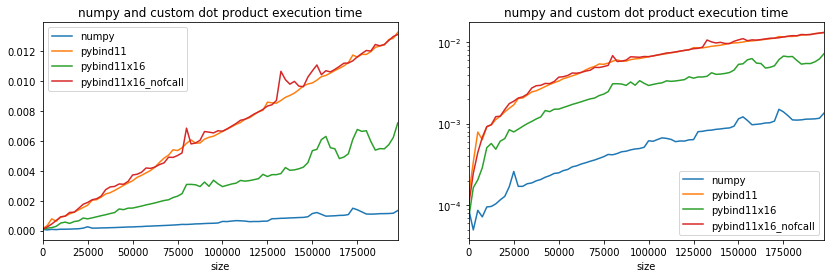

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[0], label="pybind11x16_nofcall")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[1], label="pybind11x16_nofcall")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Weird, branching did not happen when the code is not inside a separate function.

### SSE instructions

We replace one function in the previous implementation.

In [38]:
# #include <xmmintrin.h>
# 
# float vector_dot_product_pointer16_sse(const float *p1, const float *p2)
# {
#     __m128 c1 = _mm_load_ps(p1);
#     __m128 c2 = _mm_load_ps(p2);
#     __m128 r1 = _mm_mul_ps(c1, c2);
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
# 
#     float r[4];
#     _mm_store_ps(r, r1);
# 
#     return r[0] + r[1] + r[2] + r[3];
# }

In [39]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_sse
vector_dot_product16_sse(vect, vect)

3333332.0

In [40]:
def c11_dot16_sse(vect):
    return vector_dot_product16_sse(vect, vect)

measure_time("c11_dot16_sse(values)", context=dict(c11_dot16_sse=c11_dot16_sse, values=vect), repeat=10)

{'average': 0.13832661599998347,
 'deviation': 0.005508551608453958,
 'min_exec': 0.13362507299996196,
 'max_exec': 0.15111008199994558,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [41]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_sse(values)", repeat=10,
                     context=dict(c11_dot16_sse=c11_dot16_sse, values=vect[:i].copy()))
    res.append(t)

cus_dot16_sse = pandas.DataFrame(res)
cus_dot16_sse.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001797,0.000045,0.001909,0.001765,50,10,187510
76,0.001828,0.000077,0.002052,0.001787,50,10,190010
77,0.001853,0.000069,0.002050,0.001810,50,10,192510
78,0.001850,0.000032,0.001932,0.001830,50,10,195010
79,0.001893,0.000104,0.002193,0.001820,50,10,197510


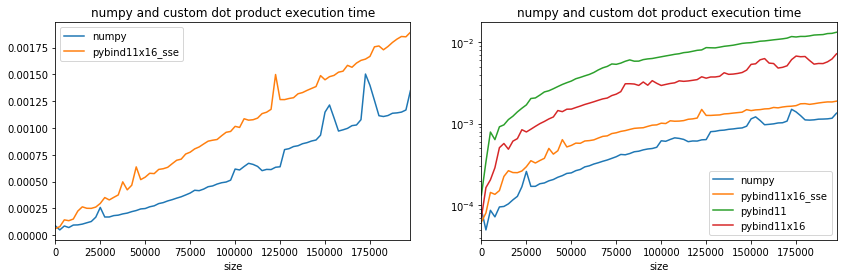

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Better even though it is still slower than *numpy*. It is closer. Maybe the compilation option are not optimized, *numpy* was also compiled with the Intel compiler. To be accurate, multi-threading must be disabled on *numpy* side. That's the purpose of the first two lines.

### AVX 512

Last experiment with [AVX 512](https://fr.wikipedia.org/wiki/Advanced_Vector_Extensions) instructions but it does not work on all processor. I could not test it on my laptop as these instructions do not seem to be available. More can be found on wikipedia [CPUs with AVX-512](https://en.wikipedia.org/wiki/AVX-512#CPUs_with_AVX-512).

In [43]:
import platform
platform.processor()

'Intel64 Family 6 Model 78 Stepping 3, GenuineIntel'

In [44]:
import numpy
values = numpy.array(list(range(10000000)), dtype=numpy.float32)
vect = values / numpy.max(values)

In [45]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_avx512
vector_dot_product16_avx512(vect, vect)

3333332.0

In [46]:
def c11_dot16_avx512(vect):
    return vector_dot_product16_avx512(vect, vect)

measure_time("c11_dot16_avx512(values)",
             context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect), repeat=10)

{'average': 0.13641321650001145,
 'deviation': 0.004238254352516503,
 'min_exec': 0.13372699900003227,
 'max_exec': 0.1486140870000554,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [47]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_avx512(values)", repeat=10,
                     context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect[:i].copy()))
    res.append(t)

cus_dot16_avx512 = pandas.DataFrame(res)
cus_dot16_avx512.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001837,0.000029,0.001903,0.001812,50,10,187510
76,0.001858,0.000024,0.001893,0.001838,50,10,190010
77,0.001886,0.000035,0.001973,0.001861,50,10,192510
78,0.001908,0.000041,0.002017,0.001882,50,10,195010
79,0.001941,0.000059,0.002108,0.001907,50,10,197510


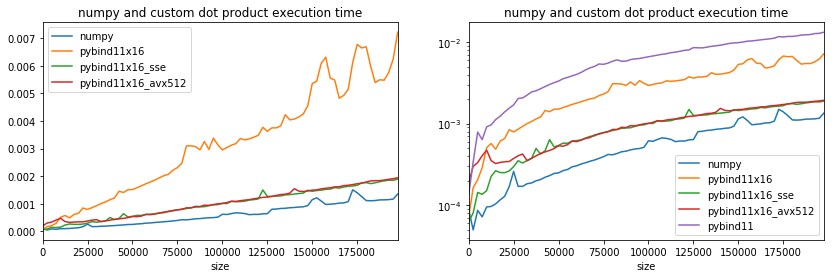

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[0], label="pybind11x16_avx512")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[1], label="pybind11x16_avx512")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

If the time is the same, it means that options AVX512 are not available.

In [49]:
from cpyquickhelper.numbers.cbenchmark import get_simd_available_option
get_simd_available_option()

'Available options:  __SSE__ __SSE2__ __SSE3__ __SSE4_1__'

### Back to numpy

This article [Why is matrix multiplication faster with numpy than with ctypes in Python?](https://stackoverflow.com/questions/10442365/why-is-matrix-multiplication-faster-with-numpy-than-with-ctypes-in-python) gives some kints on why *numpy* is still faster. By looking at the code of the dot product in *numpy*: [arraytypes.c.src](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/arraytypes.c.src), it seems that *numpy* does a simple dot product without using branching or uses the library [BLAS](http://www.netlib.org/blas/) which is the case in this benchmark (code for dot product: [sdot.c](http://www.netlib.org/clapack/cblas/sdot.c)). And it does use *branching*. See also function [blas_stride](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/common.h#L298). These libraries then play with [compilation options](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html) and optimize for speed. This benchmark does not look into [cython-blis](https://github.com/explosion/cython-blis) which implements some [BLAS](http://www.netlib.org/blas/) functions with an assembly language and has different implementations depending on the platform it is used.